In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from thesis.io import gyre, fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate

import jax
import jax.numpy as jnp
from jax import random
jax.config.update("jax_enable_x64", True)

import jaxopt

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
gong = fgong.load_fgong(filename)
gong

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [3]:
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [4]:
data = gong.merge(pulse, combine_attrs="drop_conflicts")
data

<xarray.Dataset>
Dimensions:       (x: 1046, n_pg: 36, l: 3)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
  * n_pg          (n_pg) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * l             (l) int64 0 1 2
Data variables: (12/44)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    omega         (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As            (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2           (x, n_pg, l) float64 125.5 nan 125.5 ... 5.896e+03 nan nan
    c_1           (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
    xi_r          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
Attributes: (12/17)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08
    freq_units:      UHZ
    label:

In [5]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


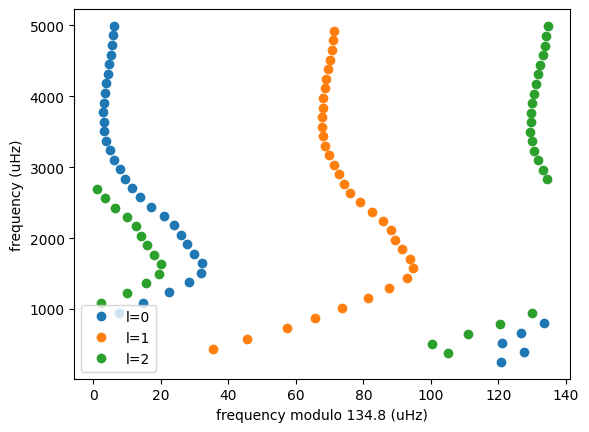

In [6]:
fig = plt.figure()

freq_mod = data.freq.real%nu0
for j in data.l:
    plt.plot(freq_mod.sel(l=j), data.freq.real.sel(l=j), 'o', color=f'C{j:d}', label=f'l={j:d}')
#     plt.plot(freq_mod.sel(l=j)-nu0, ds.freq.real.sel(l=j), 'o', color=f'C{j:d}')

plt.xlabel(f'frequency modulo {nu0:.1f} (uHz)')
plt.ylabel('frequency (uHz)')
plt.legend();

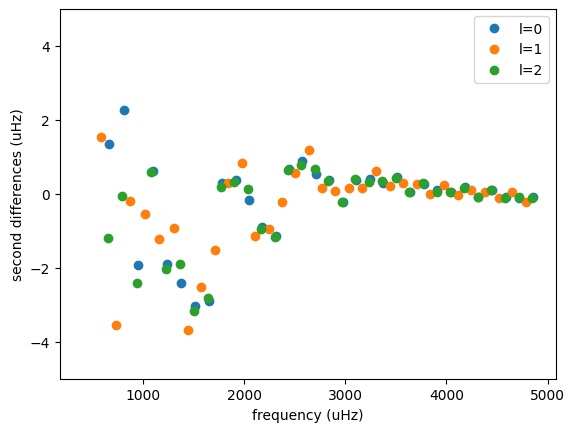

In [7]:
plt.figure()

d2nu = data.freq.real[:-2].values - 2 * data.freq.real[1:-1].values + data.freq.real[2:].values

for j in range(3):
    plt.plot(data.freq.real[1:-1, j], d2nu[:, j], 'o', color=f'C{j:d}', label=f'l={data.l[j]:d}')

plt.xlabel('frequency (uHz)')
plt.ylabel('second differences (uHz)')
plt.ylim(-5, 5)
plt.legend();

In [8]:
def _oscillation(nu, tau, phi):
    return jnp.sin(4 * jnp.pi * tau * nu + phi)

def factorial_ratio(n, m):
    # returns n!/m! where m must be less than n
    if n < m:
        raise ValueError("Variable 'n' is less than 'm'.")
    return jax.lax.prod(range(m+1, n+1))
    # return jnp.prod(jnp.arange(m+1, n+1))

In [9]:
def smooth_component(params, n):
    return jnp.polyval(params["coeff"][::-1], n)
    # num_coeff = params["coeff"].shape[-1]
    # return params["coeff"] * n[:, None]**jnp.arange(num_coeff)

def helium_amp(params, nu):
    return jnp.exp(params["log_a_he"]) * nu \
        * jnp.exp(- jnp.exp(params["log_b_he"]) * nu**2)

def helium_osc(params, nu):
    return _oscillation(nu, jnp.exp(params["log_tau_he"]), params["phi_he"])

def helium_glitch(params, nu):
    return helium_amp(params, nu) * helium_osc(params, nu)

def bcz_amp(params, nu):
    return jnp.exp(params["log_a_cz"]) / nu**2

def bcz_osc(params, nu):
    return _oscillation(nu, jnp.exp(params["log_tau_cz"]), params["phi_cz"])

def bcz_glitch(params, nu):
    return bcz_amp(params, nu) * bcz_osc(params, nu)

def glitch(params, nu):
    return helium_glitch(params, nu) + bcz_glitch(params, nu)

In [10]:
def model(params, n):
    nu_sm = smooth_component(params, n)
    dnu = glitch(params, nu_sm)
    return nu_sm + dnu

def regularise(params, n, num_deriv=3):
    num_coeff = params["coeff"].shape[-1]
    reg = jnp.zeros_like(n)
    for k in range(num_deriv, num_coeff):
        reg += factorial_ratio(k, num_coeff-num_deriv-1) \
            * params["coeff"][k] * n**(k-num_deriv)
    return reg

def least_square(params, n, nu, reg=7.0):
    return jnp.sum((nu - model(params, n))**2 + (reg * regularise(params, n))**2)

def chi_square(params, n, nu, sigma, reg=7.0):
    return jnp.sum(((nu - model(params, n))/sigma)**2 + (reg * regularise(params, n))**2)

In [11]:
l = 0
n = np.arange(12, 28)
nu = data.freq.real.sel(l=l, n_pg=n).values
delta_nu = np.diff(nu).mean()
print(f"{delta_nu=:.2f}")

delta_nu=132.97


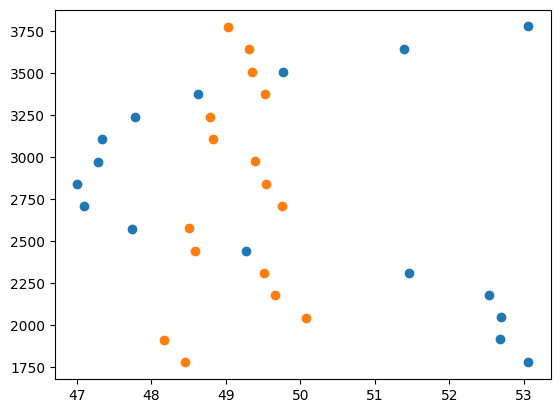

In [12]:
init_params = {
    "coeff": delta_nu * jnp.array([1.37, 1., 0., 0., 0.]),
    "log_a_he": jnp.log(1e-3),
    "log_b_he": jnp.log(2e-7),
    "log_tau_he": jnp.log(0.2/2/delta_nu),
    "phi_he": 0.0,
    "log_a_cz": jnp.log(2e6),
    "log_tau_cz": jnp.log(0.6/2/delta_nu),
    "phi_cz": 0.0,
}

nu_init = model(init_params, n)

plt.plot(nu%delta_nu, nu, "o")
plt.plot(nu_init%delta_nu, nu_init, "o")

In [13]:
scale = {
    "coeff": 0.0,
    "log_a_he": 0.1,
    "log_b_he": 0.1,
    "log_tau_he": 0.1,
    "phi_he": 0.1,
    "log_a_cz": 0.1,
    "log_tau_cz": 0.1,
    "phi_cz": 0.1,
}

In [15]:
rng = random.PRNGKey(0)

In [17]:
num_init = 10
keys = random.split(rng, num_init)

jax.vmap(
    lambda key: jax.tree_map(
        lambda x: x + random.normal(key)
#         lambda x: x + jax.tree_map(
#             lambda y: y * random.normal(key),
#             scale
#         ),
        init_params
    )
)(keys)

TypeError: unsupported operand type(s) for +: 'Array' and 'dict'

random init params in range

In [291]:
lower = {
    "coeff": jnp.full_like(init_params["coeff"], -jnp.inf),
    "log_a_he": -jnp.inf,
    "log_b_he": -jnp.inf,
    "log_tau_he": jnp.log(0.15/2/delta_nu),
    "phi_he": -jnp.inf,
    "log_a_cz": -jnp.inf,
    "log_tau_cz": jnp.log(0.5/2/delta_nu),
    "phi_cz": -jnp.inf,
}

upper = {
    "coeff": jnp.full_like(init_params["coeff"], jnp.inf),
    "log_a_he": jnp.inf,
    "log_b_he": jnp.inf,
    "log_tau_he": jnp.log(0.25/2/delta_nu),
    "phi_he": jnp.inf,
    "log_a_cz": jnp.inf,
    "log_tau_cz": jnp.log(0.7/2/delta_nu),
    "phi_cz": jnp.inf,
}

bounds = (lower, upper)

In [292]:
solver = jaxopt.ScipyMinimize(method="BFGS", fun=least_square, tol=1e-4)
sol = solver.run(init_params, n, nu, reg=0.0)

# solver = jaxopt.ScipyBoundedMinimize(method="L-BFGS-B", fun=least_square)
# sol = solver.run(init_params, bounds, n, nu, reg=1.0)

# learning_rate = 1e-1
# import optax
# opt = optax.adam(learning_rate)
# solver = jaxopt.OptaxSolver(fun=least_square, opt=opt, maxiter=5000)
# sol = solver.run(init_params, n, nu, reg=7.0)

In [293]:
sol.state

ScipyMinimizeInfo(fun_val=Array(0.00558482, dtype=float64, weak_type=True), success=True, status=0, iter_num=82)

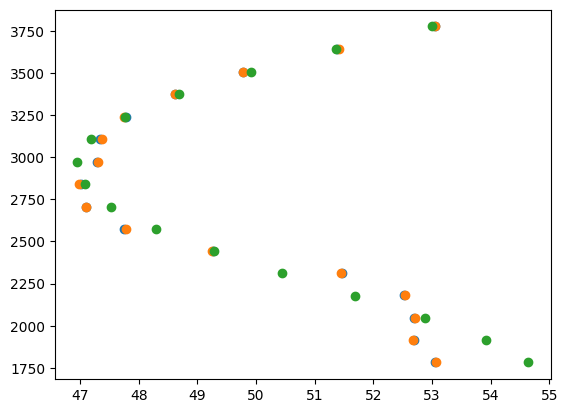

In [294]:
nu_fit = model(sol.params, n)
nu_sm = smooth_component(sol.params, n)

plt.plot(nu%delta_nu, nu, "o")
plt.plot(nu_fit%delta_nu, nu_fit, "o")
plt.plot(nu_sm%delta_nu, nu_sm, "o")

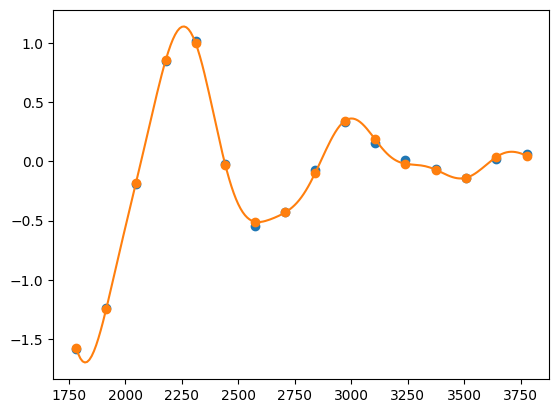

In [295]:
nu_pred = jnp.linspace(nu.min(), nu.max(), 201)
dnu_pred = glitch(sol.params, nu_pred)

dnu_fit = glitch(sol.params, nu_sm)

plt.plot(nu, nu-nu_sm, "o")
plt.plot(nu, dnu_fit, "o")
plt.plot(nu_pred, dnu_pred, c="C1")

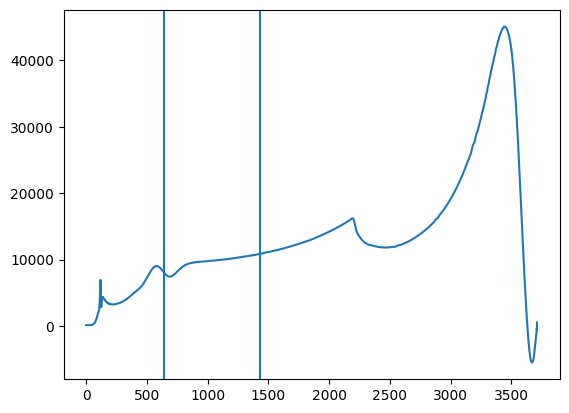

In [296]:
plt.plot(data.tau, differentiate(data.cs, data.tau))

plt.axvline(np.exp(sol.params["log_tau_he"])*1e6)
plt.axvline(np.exp(sol.params["log_tau_cz"])*1e6)

repeat for lots of initial values and pick best chi2